<a href="https://colab.research.google.com/github/bala-101/market_prediction_nifty_50/blob/main/market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import os

In [ ]:
if os.path.exists("nifty50.csv"):
    nifty50 = pd.read_csv("nifty50.csv", index_col=0)
else:
    nifty50 = yf.Ticker("^GSPC")
    nifty50 = nifty50.history(period="max")
    nifty50.to_csv("nifty50.csv")

In [ ]:
nifty50.index = pd.to_datetime(nifty50.index)

In [ ]:
nifty50

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-06 00:00:00-04:00,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,0.0,0.0
2024-08-07 00:00:00-04:00,5293.129883,5330.640137,5195.540039,5199.500000,4558260000,0.0,0.0
2024-08-08 00:00:00-04:00,5252.569824,5328.029785,5233.850098,5319.310059,4016830000,0.0,0.0


<Axes: xlabel='Date'>

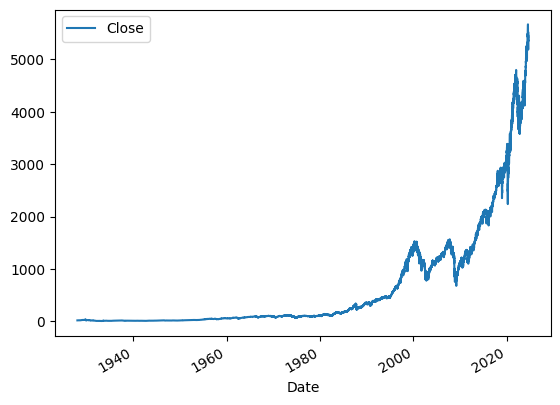

In [ ]:
nifty50.plot.line(y="Close", use_index=True)

In [ ]:
del nifty50["Dividends"]
del nifty50["Stock Splits"]

In [ ]:
nifty50["Tomorrow"] = nifty50["Close"].shift(-1)

In [ ]:
nifty50["Target"] = (nifty50["Tomorrow"] > nifty50["Close"]).astype(int)

In [ ]:
nifty50 = nifty50.loc["1990-01-01":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = nifty50.iloc[:-100]
test = nifty50.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5714285714285714

<Axes: xlabel='Date'>

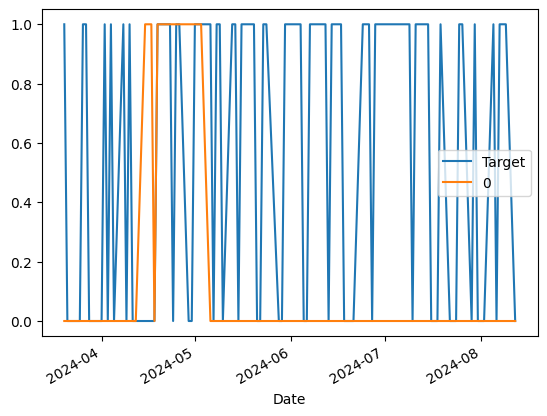

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(nifty50, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3623
1,2596


In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.535295
0,0.464705


In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nifty50.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    nifty50[ratio_column] = nifty50["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    nifty50[trend_column] = nifty50.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [ ]:
nifty50 = nifty50.dropna(subset=nifty50.columns[nifty50.columns != "Tomorrow"])

In [ ]:
nifty50

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-06 00:00:00-04:00,5206.419922,5312.339844,5193.560059,5240.029785,4690190000,5199.500000,0,1.005150,1.0,0.979741,2.0,0.966980,36.0,1.071107,141.0,1.220313,527.0
2024-08-07 00:00:00-04:00,5293.129883,5330.640137,5195.540039,5199.500000,4558260000,5319.310059,1,0.996118,1.0,0.984042,1.0,0.959569,35.0,1.062187,141.0,1.210360,527.0
2024-08-08 00:00:00-04:00,5252.569824,5328.029785,5233.850098,5319.310059,4016830000,5344.160156,1,1.011390,1.0,1.011594,2.0,0.981385,36.0,1.085908,141.0,1.237691,527.0


In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(nifty50, model, new_predictors)

In [ ]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,4379
1.0,840


In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.575

In [ ]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.544932
0,0.455068


In [ ]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2024-08-06 00:00:00-04:00,0,0.0
2024-08-07 00:00:00-04:00,1,0.0
2024-08-08 00:00:00-04:00,1,0.0
